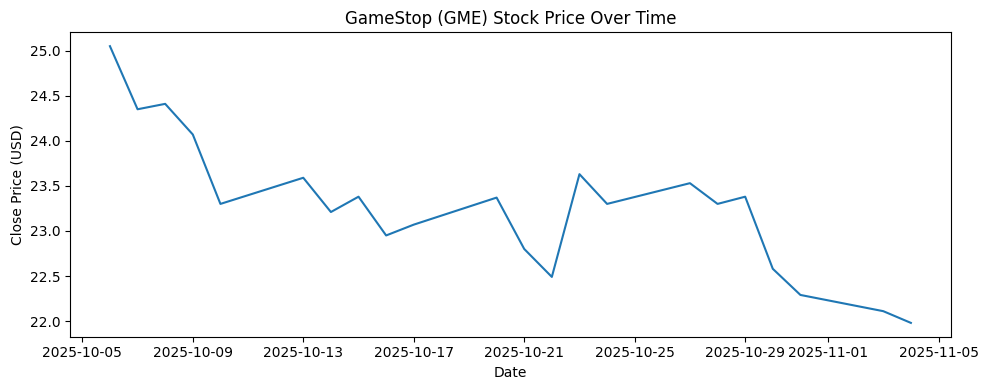

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

def fetch_gme():
    # group_by="column" prevents MultiIndex columns like ('Close','GME')
    df = yf.download("GME", group_by="column", auto_adjust=False, progress=False)
    if df is None or df.empty:
        raise RuntimeError("No data returned for GME. Check internet access and try again.")
    return df

def _normalize_for_plot(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # If columns are MultiIndex, flatten to first level: ('Close','GME') -> 'Close'
    if isinstance(out.columns, pd.MultiIndex):
        out.columns = [c[0] if isinstance(c, tuple) else c for c in out.columns]

    # Ensure a 'Date' column exists
    if 'Date' not in out.columns:
        if isinstance(out.index, (pd.DatetimeIndex, pd.PeriodIndex)):
            out = out.reset_index().rename(columns={'index': 'Date'})
            # Some environments name the first column 'Date' after reset_index; ensure it
            if 'Date' not in out.columns:
                out = out.rename(columns={out.columns[0]: 'Date'})
        else:
            out = out.reset_index().rename(columns={out.columns[0]: 'Date'})

    # Ensure we have a usable close price
    for cand in ['Close', 'Adj Close', 'Price', 'AdjClose', 'close', 'last']:
        if cand in out.columns:
            out['Close'] = out[cand]
            break
    if 'Close' not in out.columns:
        raise KeyError(f"Couldn't find a closing-price column. Columns: {list(out.columns)}")

    # Clean and order
    out['Date'] = pd.to_datetime(out['Date'], errors='coerce')
    out = out.dropna(subset=['Date', 'Close']).sort_values('Date')
    return out[['Date', 'Close']]

def make_graph(stock_df: pd.DataFrame, title: str):
    df = _normalize_for_plot(stock_df)
    plt.figure(figsize=(10, 4))
    plt.plot(df['Date'], df['Close'])
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Close Price (USD)')
    plt.tight_layout()
    plt.show()

# ---- Run for Q6 ----
gme_data = fetch_gme()
make_graph(gme_data, "GameStop (GME) Stock Price Over Time")
